## **Step 1: Loading and Processing the Data**

In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
# Path to dataset
dataset_path = "fashion"

# Get list of categories
categories = os.listdir(dataset_path)
print("Categories:", categories)

# Prepare storage for images and labels
image_data = []
labels = []

# Set image size for consistency
image_size = (28, 28)

Categories: ['ankleboot', 'bag', 'coat', 'dress', 'pullover', 'sandal', 'shirt', 'sneaker', 'trouser', 'tshirt-top']


In [3]:
# Load images and store first 5 images for visualization
sample_images = {category: [] for category in categories}

for label, category in enumerate(categories):
    category_path = os.path.join(dataset_path, category)
    # Track number of images processed per category
    count = 0 
    
    for image_name in os.listdir(category_path):
        image_path = os.path.join(category_path, image_name)

        # Open, resize, and convert image to grayscale
        img = Image.open(image_path).convert("L")
        img = img.resize(image_size)
        # Flatten image into 1D array
        img_array = np.array(img).flatten()  

        # Store the image data and corresponding label
        image_data.append(img_array)
        labels.append(label)

        # Store sample images (only first 5 per category)
        if count < 5:
            sample_images[category].append(np.array(img))  # Store raw image for display
            count += 1

In [4]:
# Convert to NumPy arrays
X = np.array(image_data)
y = np.array(labels)

# Tests
print(f"Number of images and pixel size: {X.shape}")
print(f"Number of labels: {y.shape}")
print(f"Number of catagories: {len(categories)}")

Number of images and pixel size: (70000, 784)
Number of labels: (70000,)
Number of catagories: 10


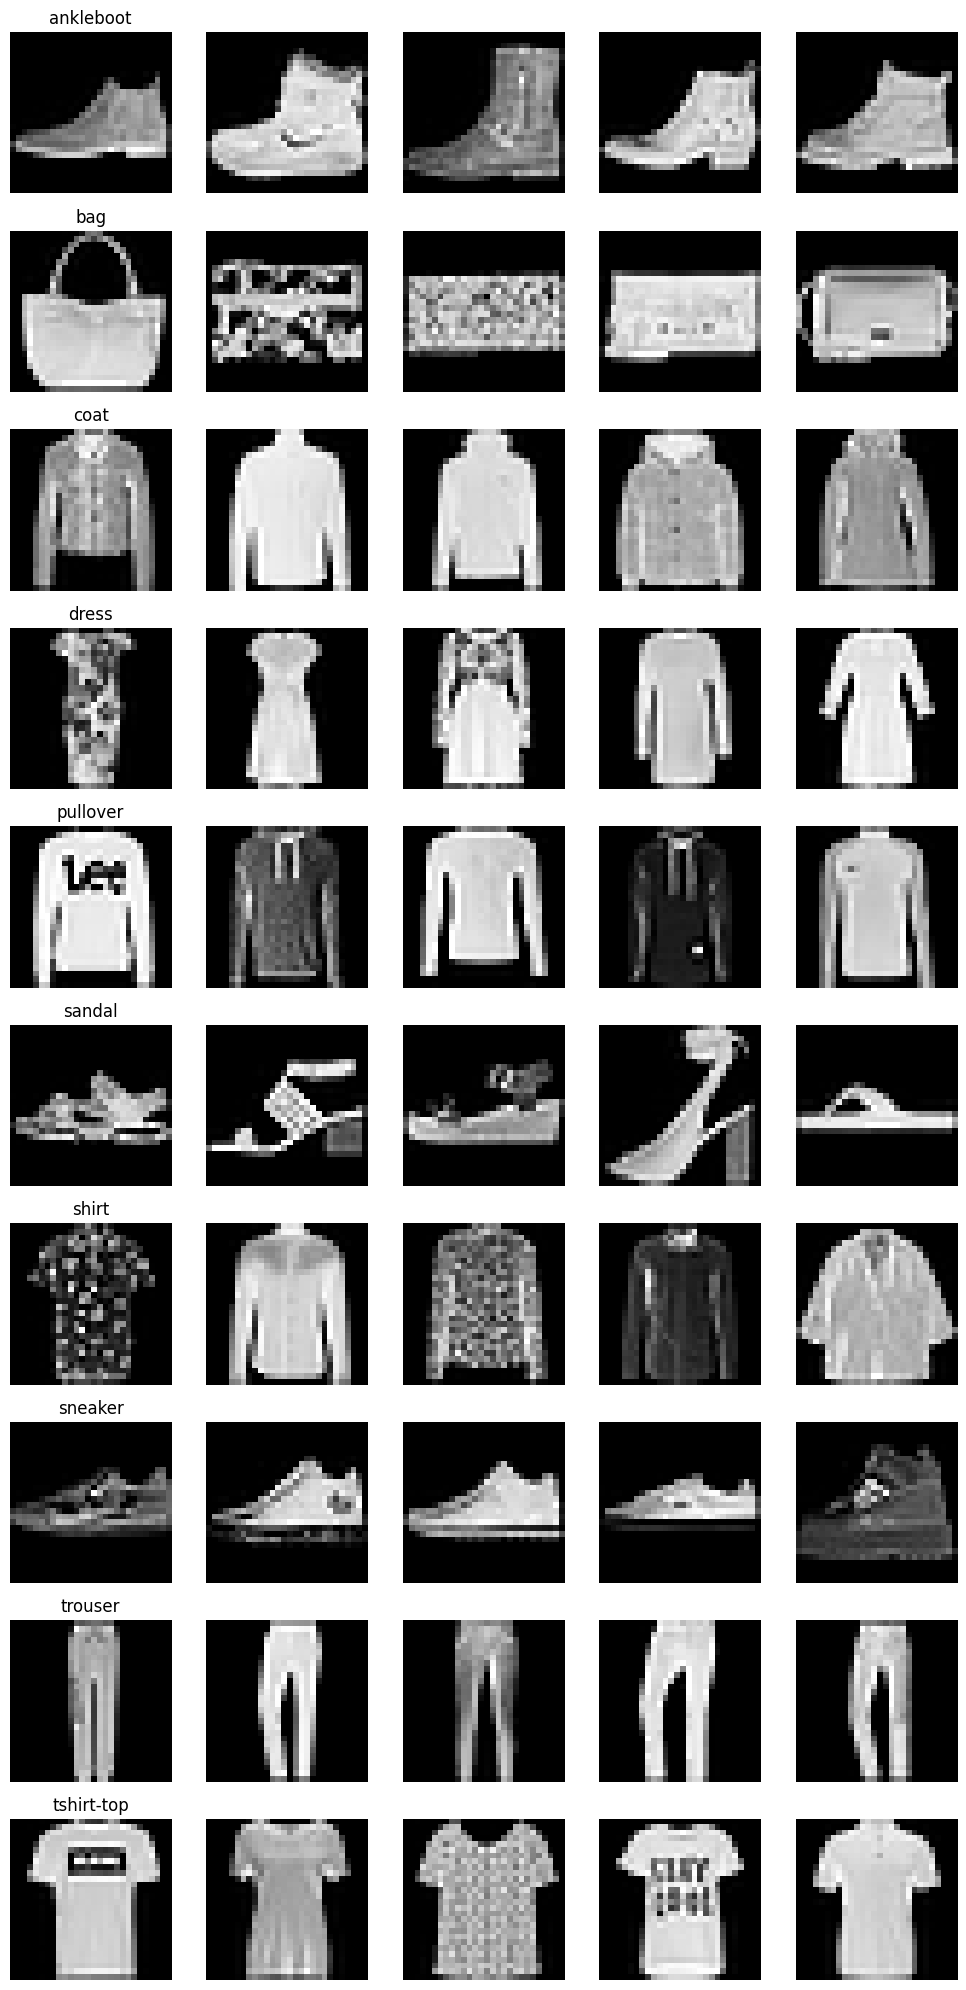

In [5]:
# Display sample images (5 per category)
fig, axes = plt.subplots(len(categories), 5, figsize=(10, len(categories) * 2))

for row, category in enumerate(categories):
    for col in range(5):
        if col < len(sample_images[category]):
            axes[row, col].imshow(sample_images[category][col], cmap="gray")
            axes[row, col].axis("off")
            axes[row, col].set_title(category if col == 0 else "")

plt.tight_layout()
plt.show()

## **Step 2: Normalising the Data**

In [6]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [7]:
# Normalise pixel values to range [0, 1]
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [8]:
print(f"Min pixel value after scaling: {X.min()}")
print(f"Max pixel value after scaling: {X.max()}")
print(f"Min pixel value after scaling: {X_scaled.min()}")
print(f"Max pixel value after scaling: {X_scaled.max()}")
print("Data normalized successfully!")

Min pixel value after scaling: 0
Max pixel value after scaling: 255
Min pixel value after scaling: 0.0
Max pixel value after scaling: 1.0
Data normalized successfully!


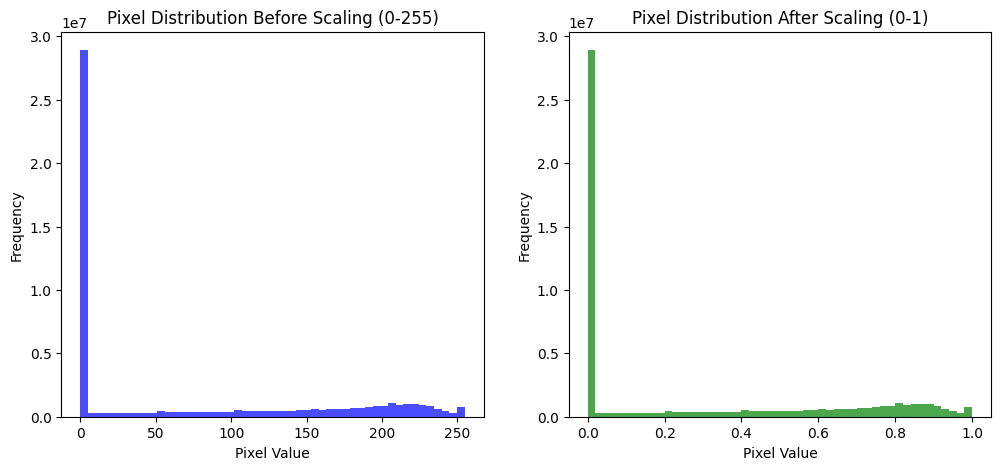

In [9]:
plt.figure(figsize=(12, 5))

# Histogram before scaling
plt.subplot(1, 2, 1)
plt.hist(X.flatten(), bins=50, color='blue', alpha=0.7)
plt.title("Pixel Distribution Before Scaling (0-255)")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")

# Histogram after scaling
plt.subplot(1, 2, 2)
plt.hist(X_scaled.flatten(), bins=50, color='green', alpha=0.7)
plt.title("Pixel Distribution After Scaling (0-1)")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")

plt.show()


## **Step 4. Spliting Data into Training and Testing Sets**

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
# Use Student ID G00409920 (without G and leading 0s) as random seed
student_id = 409920
np.random.seed(student_id)

# Split dataset into train (70%), other (30%)
X_train, X_other, y_train, y_other = train_test_split(
    X_scaled, y, test_size=0.3, stratify=y, random_state=student_id
)

# Split other into validation (15%) and test (15%)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_other, y_other, test_size=0.5, stratify=y_other, random_state=student_id
)

In [12]:
# Print the dataset sizes
print(f"Training set: {len(X_train)} samples")
print(f"Validation set: {len(X_valid)} samples")
print(f"Test set: {len(X_test)} samples")

Training set: 49000 samples
Validation set: 10500 samples
Test set: 10500 samples


## **Step 5: Training the Models**

### Training and Evaluating SVM

In [13]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

In [ ]:
# Train SVM with linear kernel
svm_model = SVC(kernel="linear", class_weight="balanced", random_state=student_id)

# Perform 5-fold cross-validation
svm_scores = cross_val_score(svm_model, X_train, y_train, cv=5)

# Print performance for each fold
print("SVM Cross-Validation Results (5 folds):")
for fold_index, score in enumerate(svm_scores, start=1):
    print(f" Fold {fold_index} Accuracy: {score:.4f}")

# Print average and standard deviation
print(f"\nMean Accuracy: {svm_scores.mean():.4f} ± {svm_scores.std():.4f}")


SVM Cross-Validation Results (5 folds):
 Fold 1 Accuracy: 0.8529
 Fold 2 Accuracy: 0.8472
 Fold 3 Accuracy: 0.8528
 Fold 4 Accuracy: 0.8595
 Fold 5 Accuracy: 0.8465

Mean Accuracy: 0.8518 ± 0.0047


In [16]:
# Train on full training set
svm_model.fit(X_train, y_train)

# Evaluate on validation set
y_valid_pred = svm_model.predict(X_valid)
svm_valid_accuracy = accuracy_score(y_valid, y_valid_pred)

print(f"SVM Validation Accuracy: {svm_valid_accuracy:.4f}")


SVM Validation Accuracy: 0.8623


In [22]:
# Evaluate on the test set (unseen data)
y_test_pred = svm_model.predict(X_test)
svm_test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"SVM Test Accuracy: {svm_test_accuracy:.4f}")

SVM Test Accuracy: 0.8550
